# Installation

In [1]:
# Importation des différentes librairies utiles pour le notebook
#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
from numpy import mean, std
import string
import os
from os import listdir
from os.path import isfile, join
import time
import base64
import re
import sys
import copy
import random
import datetime
import glob
from glob import glob
import cv2
import zipfile

# librairie affichage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow et keras
import tensorflow as tf
from tensorflow.keras.losses import mse
import tensorflow._api.v2.compat.v1 as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import LeakyReLU
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.layers import InputLayer, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
# pour monter son drive Google Drive local
from google.colab import drive
import sys
drive.mount('/content/gdrive')

my_local_drive='/content/gdrive/MyDrive/Colab Notebooks/ML2_2023_2024'

# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd


Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/MyDrive/Colab Notebooks/ML2_2023_2024'

#VAE

## Jeu de données

In [108]:
tf.disable_v2_behavior()

DATA_FOLDER = "snow_fox"
NUM_IMAGES=len(os.listdir(DATA_FOLDER))
EPOCH=25
WEIGHTS_FOLDER = './myweights/'

# Get all the file names with extension .jpg from DATA_FOLDER/train
filenames = np.array(glob(os.path.join(DATA_FOLDER+'/train', '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 8 # batchsize dimension
Z_DIM = 100 # Dimension of the latent vector

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_flow = datagen.flow_from_directory(DATA_FOLDER,
                                        classes=['train'],
                                          target_size = INPUT_DIM[:2],
                                          batch_size = BATCH_SIZE,
                                          shuffle = True,
                                          color_mode='rgb',
                                          class_mode = 'input'
                                          )



Total number of images : 50
Found 50 images belonging to 1 classes.


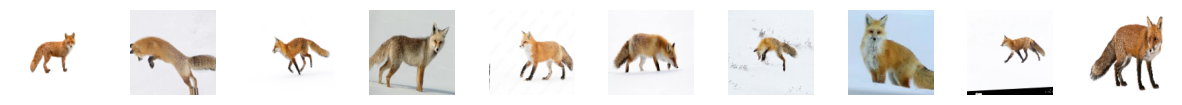

In [59]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_to_show = 10
for i in range(n_to_show):
    img = next(data_flow)[0][0]
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img)

In [60]:
def sssampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2) * epsilon

def ssvae_loss(y_true, y_pred, mean_mu, log_var):
    reconstruction_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

## Encoder

In [109]:
def build_vae_encoder(input_dim, output_dim):
  # By using clear_session we remove all the previous runs. That's a way to re-initialize
  global K
  K.clear_session()

  #  model input
  vae_encoder_input = Input(shape = input_dim, name = 'vae_encoder_input')
  x = vae_encoder_input

  # First convolution
  x= Conv2D(filters = 32,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_1')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_2')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_3')(x)
  # Applying the activation function
  x = LeakyReLU()(x)

   # Fourth Convolution
  x= Conv2D(filters = 64,
            kernel_size = 3,
            strides = 2,
            padding = 'same', name = 'vae_encoder_conv_4')(x)
  # Applying the activation function
  x = LeakyReLU()(x)


  # We need to get the latest shape before applying flatten for the decoder
  shape_before_flattening = K.int_shape(x)[1:]

  # Flatten the last CNN
  x = Flatten()(x)

  # Difference from the previous encoder
  # create a layer for the mean
  mean_mu = Dense(output_dim, name = 'mu')(x)
  # create a layer for the standard deviation
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon

  # Using a Keras Lambda Layer to include the sampling function as a layer
  # in the model. This is important for the gradient descent
  vae_encoder_output = Lambda(sampling, name='vae_encoder_output')([mean_mu, log_var])


  return vae_encoder_input, vae_encoder_output, mean_mu, log_var, shape_before_flattening, Model(vae_encoder_input, vae_encoder_output)


In [110]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    )
print(shape_before_flattening)
vae_encoder.summary()

(8, 8, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vae_encoder_input (InputLa  [(None, 128, 128, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 vae_encoder_conv_1 (Conv2D  (None, 64, 64, 32)           896       ['vae_encoder_input[0][0]']   
 )                                                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['vae_encoder_conv_1[0][0]']  
                                                                                   

## Decoder

In [111]:
def build_vae_decoder(input_dim, shape_before_flattening):
  # Define model input
  vae_decoder_input = Input(shape = (input_dim,) , name = 'vae_decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(vae_decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # First Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_1'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Second Conv2DTranspose layer
  x = Conv2DTranspose(filters = 64,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_2'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Third Conv2DTranspose layer
  x = Conv2DTranspose(filters = 32,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_3'
                  )(x)
  # Applying the activation function
  x = LeakyReLU()(x)

  # Fouth Conv2DTranspose layer
  x = Conv2DTranspose(filters = 3,
                  kernel_size = 3,
                  strides = 2,
                  padding = 'same',
                  name = 'vae_decoder_conv_4'
                  )(x)
  # Applying the activation function
  x = Activation('sigmoid')(x)

  vae_decoder_output = x

  return vae_decoder_input, vae_decoder_output, Model(vae_decoder_input, vae_decoder_output)

In [112]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_vae_decoder(input_dim = Z_DIM, shape_before_flattening = shape_before_flattening)
vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vae_encoder_input (InputLa  [(None, 128, 128, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 vae_encoder_conv_1 (Conv2D  (None, 64, 64, 32)           896       ['vae_encoder_input[0][0]']   
 )                                                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['vae_encoder_conv_1[0][0]']  
                                                                                              

## création du VAE

In [113]:
B = 10000

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def total_loss(y_true, y_pred):
    return B*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [114]:
vae_autoencoder_input = vae_encoder_input
vae_autoencoder_output = vae_decoder(vae_encoder_output)

vae_autoencoder = Model(vae_autoencoder_input, vae_autoencoder_output)
#vae_autoencoder.add_loss(vae_loss(vae_autoencoder_input, vae_autoencoder_output, mean_mu, log_var))

vae_autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vae_encoder_input (InputLa  [(None, 128, 128, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 vae_encoder_conv_1 (Conv2D  (None, 64, 64, 32)           896       ['vae_encoder_input[0][0]']   
 )                                                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['vae_encoder_conv_1[0][0]']  
                                                                                            

## Entrainement

In [130]:
val_data_flow=next(data_flow)
steps_per_epoch=int(NUM_IMAGES / BATCH_SIZE)
##params
LEARNING_RATE = 0.0001
B=15000
##
checkpoint_name = "cbon_B"+str(B)+"_BS"+str(BATCH_SIZE)+"_Z"+str(Z_DIM)
periodic_checkpoint_vae_autoencoder = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, checkpoint_name+'_{epoch:03d}.h5'), save_weights_only = True, verbose=1,period = 250)
checkpoint_vae_autoencoder = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, checkpoint_name+'_best.h5'), save_weights_only = True, verbose=1,period=5)
print(checkpoint_name)

cbon_B15000_BS8_Z100


In [131]:
vae_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss = total_loss, metrics = [r_loss, kl_loss])

history=vae_autoencoder.fit(data_flow,
                      epochs = 6000,
                      shuffle=True,
                      initial_epoch = 3950,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=val_data_flow,
                      callbacks=[periodic_checkpoint_vae_autoencoder,checkpoint_vae_autoencoder])

Epoch 3951/6000
6/6 [==============================] - 3s 248ms/step - batch: 2.5000 - size: 8.0000 - loss: 165.6156 - r_loss: 0.0074 - kl_loss: 54.6257 - val_loss: 159.2393 - val_r_loss: 0.0070 - val_kl_loss: 53.7523
Epoch 3952/6000
6/6 [==============================] - 1s 220ms/step - batch: 2.5000 - size: 6.0000 - loss: 164.9474 - r_loss: 0.0072 - kl_loss: 54.7217 - val_loss: 165.4154 - val_r_loss: 0.0075 - val_kl_loss: 53.2186
Epoch 3953/6000
6/6 [==============================] - 1s 218ms/step - batch: 2.5000 - size: 7.0000 - loss: 160.7784 - r_loss: 0.0071 - kl_loss: 53.2165 - val_loss: 161.4553 - val_r_loss: 0.0073 - val_kl_loss: 52.1208
Epoch 3954/6000
6/6 [==============================] - 2s 311ms/step - batch: 2.5000 - size: 7.0000 - loss: 174.3189 - r_loss: 0.0081 - kl_loss: 54.7549 - val_loss: 160.5548 - val_r_loss: 0.0072 - val_kl_loss: 52.5672
Epoch 3955/6000
6/6 [==============================] - ETA: 0s - batch: 2.5000 - size: 8.0000 - loss: 159.0244 - r_loss: 0.0071 

##Charger poids

In [12]:
vae_autoencoder.load_weights('./myweights/'+checkpoint_name+'_best.h5')

In [98]:
name = "cbon_B15000_BS8_Z100"
vae_autoencoder.load_weights('./myweights/'+name+'_best.h5')

#Tester le modèle

In [144]:
def show_images(autoencoder, images=None):
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  reconst_images = autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

def generate_images_from_noise(n_to_show = 10):
  # For n_to_show images, we create a normal distribution sample on between 0 and 1
  normal_distribution_sample= np.random.normal(0,1,size=(n_to_show,Z_DIM))

  # we apply the decoder part to the samples to see what is generated
  reconst_images = vae_decoder.predict(normal_distribution_sample)

  # Plots the figures
  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

In [160]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

250 epochs

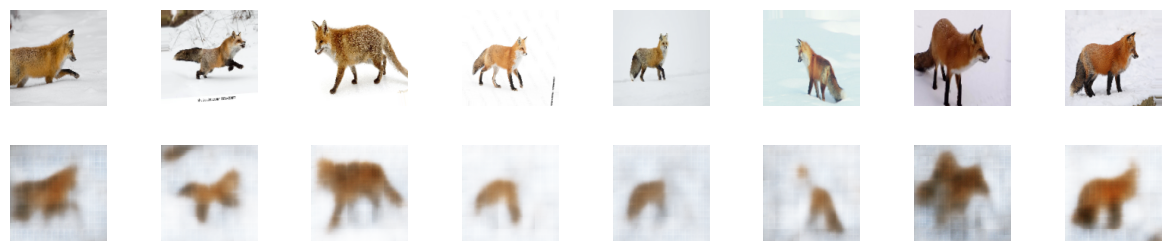

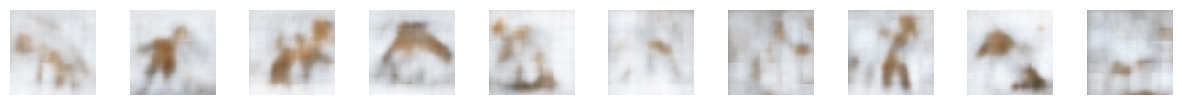

In [161]:
name = "cbon_B15000_BS8_Z100"
vae_autoencoder.load_weights('./myweights/'+name+'_250.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

500 epochs

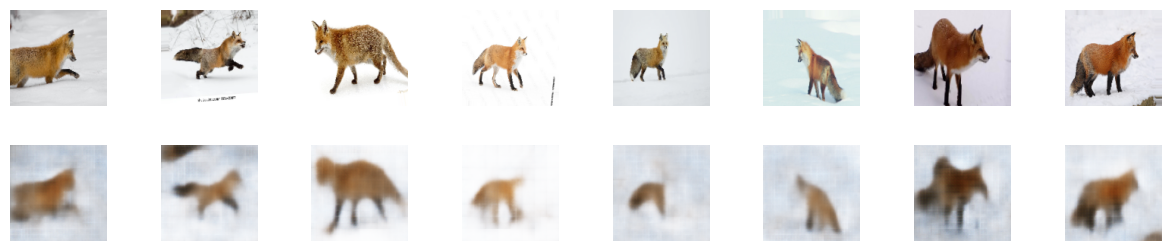

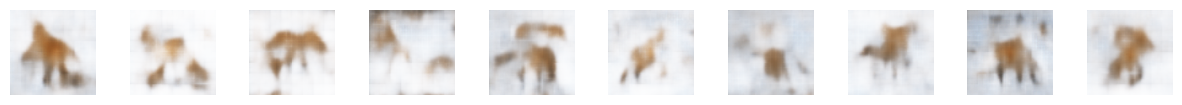

In [162]:
vae_autoencoder.load_weights('./myweights/'+name+'_500.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

1000 epochs

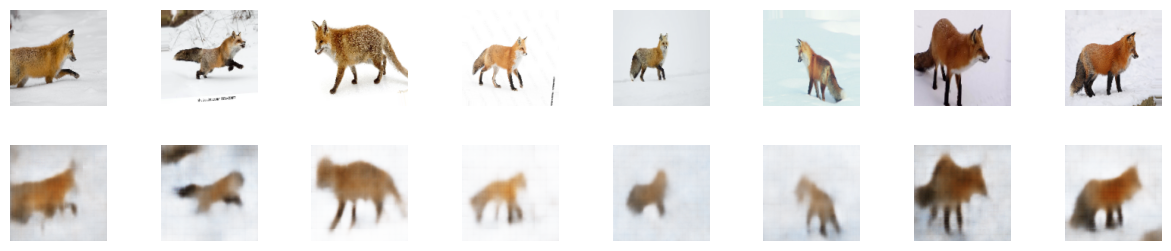

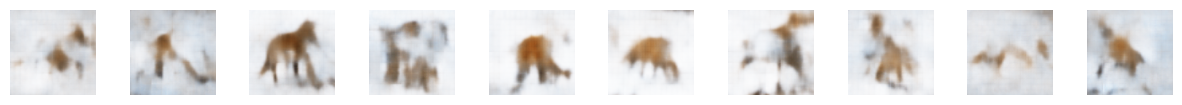

In [163]:
vae_autoencoder.load_weights('./myweights/'+name+'_1000.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

2000 epochs

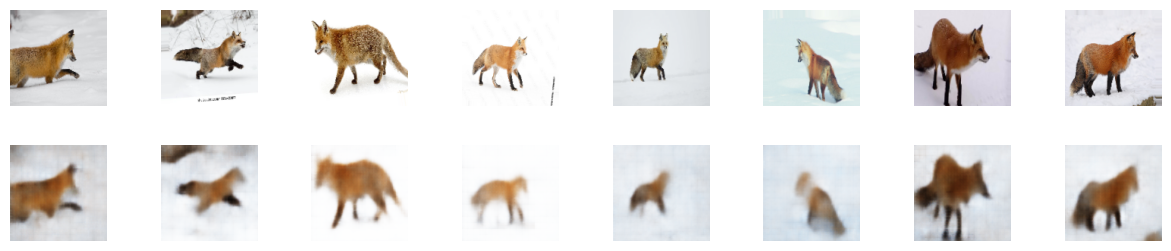

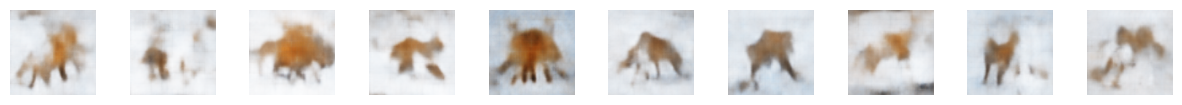

In [164]:
vae_autoencoder.load_weights('./myweights/'+name+'_2000.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

3000 epochs

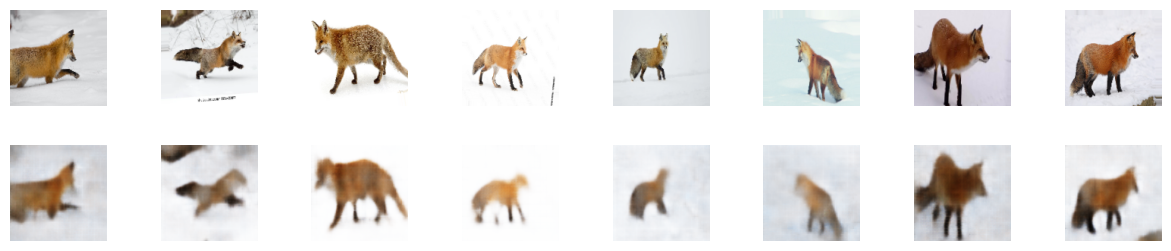

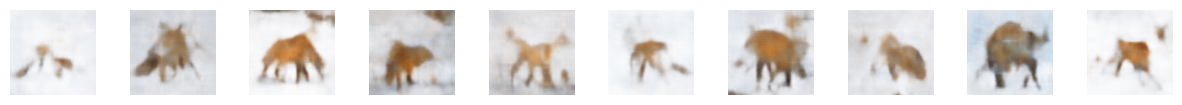

In [165]:
vae_autoencoder.load_weights('./myweights/'+name+'_3000.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

4200 epochs

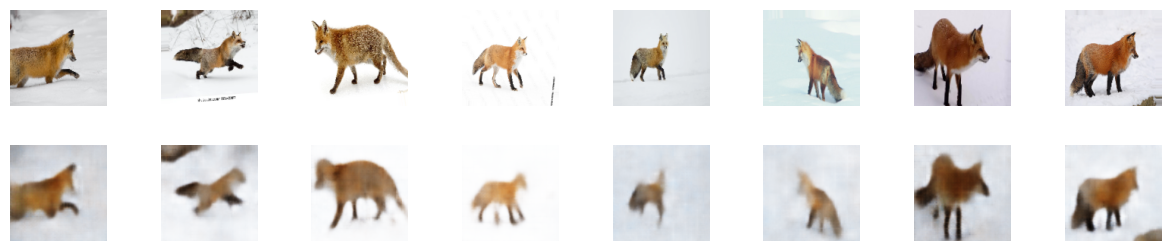

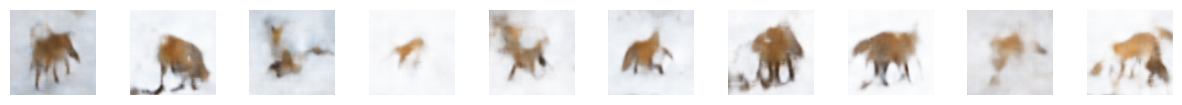

In [166]:
vae_autoencoder.load_weights('./myweights/'+name+'_4200.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

6000 epochs

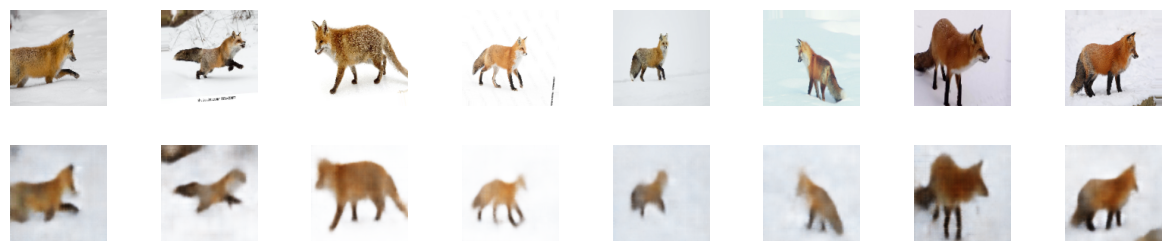

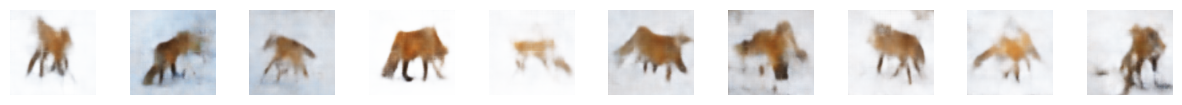

In [167]:
vae_autoencoder.load_weights('./myweights/'+name+'_best.h5')
show_images(vae_autoencoder,example_images)
generate_images_from_noise()

In [ ]:
def generate_images_from_noise(n_to_show=10):
    # For n_to_show images, we create a normal distribution sample between 0 and 1
    normal_distribution_sample = np.random.normal(0, 1, size=(n_to_show, Z_DIM))

    # we apply the decoder part to the samples to see what is generated
    reconst_images = vae_decoder.predict(normal_distribution_sample)

    # Plots the figures
    fig = plt.figure(figsize=(15, 15))  # Increase figure size
    rows = int(np.ceil(n_to_show / 4))  # Calculate number of rows needed
    columns = 4  # Set number of columns per row
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(rows, columns, i + 1)  # Update subplot position
        sub.axis('off')
        sub.imshow(img)

generate_images_from_noise()